In [ ]:
#Import Library
import pathlib
import keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the paths to your training, validation and test datasets
training_dir = '/content/drive/MyDrive/Masakan'
validation_dir = '/content/drive/MyDrive/Masakan'
test_dir = '/content/drive/MyDrive/Masakan'

In [ ]:
# We can check image shape using this code
import cv2
import numpy as np

# Load the image
image = cv2.imread('/content/drive/MyDrive/Masakan/CAPCAY/capcay (1).jpeg')

# Check the shape of the image
height, width, channels = image.shape
# Dataset comprises of images of shape: (150,150,3)
# Print the image shape
print(f"Image shape: (height={height}, width={width}, channels={channels})")

Image shape: (height=183, width=276, channels=3)


In [ ]:
# Define data augmentation for training
datagen = ImageDataGenerator(
    rescale=1./255,
)


# Data Generation for train, validation and Test
train_generator = datagen.flow_from_directory(
    training_dir,
    target_size=(128,128),
    batch_size=32,
    shuffle = True,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
    )
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(128,128),
    batch_size=32,
    shuffle = True,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    shuffle = True,
    class_mode='categorical'
)

Found 3113 images belonging to 5 classes.
Found 3113 images belonging to 5 classes.
Found 3113 images belonging to 5 classes.


In [ ]:
from sklearn.model_selection import train_test_split

# Misalkan 'data' adalah data Anda tanpa label
data = '/content/drive/MyDrive/Masakan'  # Sesuaikan dengan data Anda

# Pisahkan data menjadi train (80%), validation (10%), dan test (10%)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Output ukuran set data
print("Jumlah data pelatihan:", len(train_data))
print("Jumlah data validasi:", len(validation_data))
print("Jumlah data uji:", len(test_data))


Jumlah data pelatihan: 24
Jumlah data validasi: 3
Jumlah data uji: 3


In [ ]:
import numpy as np

# Simpan data pelatihan, validasi, dan uji ke dalam file
np.save('train_data.npy', train_data)
np.save('validation_data.npy', validation_data)
np.save('test_data.npy', test_data)

In [ ]:
# Data Augmentation can also be applied using ImageDataGenerator but this method of applying augmentation in layer is more efficient in GPU usage
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    ])

In [ ]:
# Model Architecture
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128, 3))

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(128,128, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  # Adjust NUM_CLASSES to your task

model = Model(inputs, predictions)


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None   0         
                             )                                   
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/15
98/98 [==============================] - 833s 8s/step - loss: 0.7213 - accuracy: 0.7607 - val_loss: 0.6201 - val_accuracy: 0.8593
Epoch 2/15
98/98 [==============================] - 30s 300ms/step - loss: 0.4232 - accuracy: 0.8554 - val_loss: 0.4670 - val_accuracy: 0.8448
Epoch 3/15
98/98 [==============================] - 36s 365ms/step - loss: 0.3481 - accuracy: 0.8808 - val_loss: 0.3609 - val_accuracy: 0.8763
Epoch 4/15
98/98 [==============================] - 32s 329ms/step - loss: 0.3075 - accuracy: 0.8872 - val_loss: 0.2002 - val_accuracy: 0.9390
Epoch 5/15
98/98 [==============================] - 28s 291ms/step - loss: 0.2720 - accuracy: 0.9056 - val_loss: 0.2207 - val_accuracy: 0.9252
Epoch 6/15
98/98 [==============================] - 31s 317ms/step - loss: 0.2735 - accuracy: 0.9097 - val_loss: 0.2076 - val_accuracy: 0.9293
Epoch 7/15
98/98 [==============================] - 29s 299ms/step - loss: 0.2617 - accuracy: 0.9097 - val_loss: 0.1793 - val_accuracy: 0.9451
E

# New Section

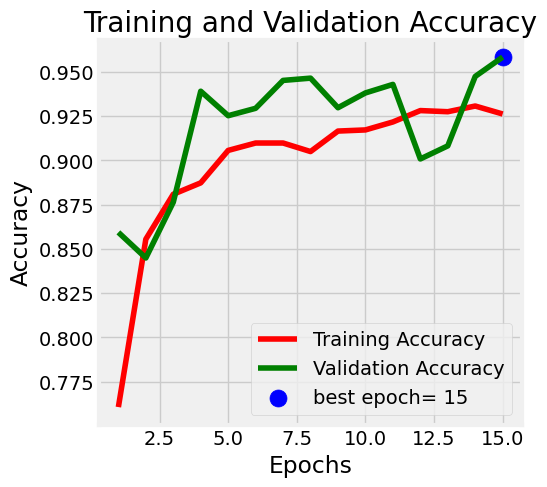

In [ ]:
# Training and Validation Accuracy plot
import matplotlib.pyplot as plt

# Define needed variables
tr_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]

acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (12, 5))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [ ]:
## Fine tuning to improve accuracy
base_model.trainable = True


custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping( monitor='val_accuracy',patience=5,restore_best_weights=True)

# Train the model with fine-tuning
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    )

Epoch 1/20
98/98 [==============================] - 110s 1s/step - loss: 0.1598 - accuracy: 0.9412 - val_loss: 0.0923 - val_accuracy: 0.9663
Epoch 2/20
98/98 [==============================] - 38s 387ms/step - loss: 0.1125 - accuracy: 0.9631 - val_loss: 0.0523 - val_accuracy: 0.9810
Epoch 3/20
98/98 [==============================] - 39s 401ms/step - loss: 0.0685 - accuracy: 0.9778 - val_loss: 0.0427 - val_accuracy: 0.9852
Epoch 4/20
98/98 [==============================] - 34s 343ms/step - loss: 0.0556 - accuracy: 0.9827 - val_loss: 0.0361 - val_accuracy: 0.9897
Epoch 5/20
98/98 [==============================] - 31s 318ms/step - loss: 0.0475 - accuracy: 0.9859 - val_loss: 0.0189 - val_accuracy: 0.9955
Epoch 6/20
98/98 [==============================] - 32s 332ms/step - loss: 0.0521 - accuracy: 0.9827 - val_loss: 0.0171 - val_accuracy: 0.9961
Epoch 7/20
98/98 [==============================] - 33s 338ms/step - loss: 0.0321 - accuracy: 0.9910 - val_loss: 0.0119 - val_accuracy: 0.9978
E

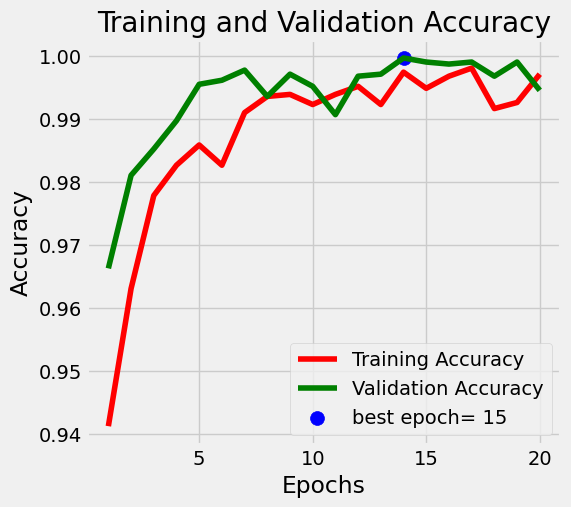

In [ ]:
# Training and Validation Accuracy plot

# Define needed variables
tr_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history
plt.figure(figsize= (12, 5))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 100, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
loss, accuracy = model.evaluate(val_generator)
print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

98/98 [==============================] - 21s 214ms/step - loss: 0.0180 - accuracy: 0.9945
Test loss: 0.0180, accuracy: 0.9945


In [ ]:
from sklearn.metrics import classification_report, f1_score
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis = 1)

98/98 [==============================] - 15s 154ms/step


In [ ]:
import pandas as pd

classes = dict(zip(val_generator.class_indices.values(), val_generator.class_indices.keys()))
Predictions = pd.DataFrame({
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(val_generator), axis = 1))]
                           })
Predictions.head(3113)

98/98 [==============================] - 20s 198ms/step


,Prediction Labels,Prediction Classes,Prediction Probability
0,0,CAPCAY,0.999819
1,2,NASI GORENG,0.999940
2,1,KENTANG GORENG,0.999506
3,1,KENTANG GORENG,0.998948
4,1,KENTANG GORENG,0.999994
...,...,...,...
3108,1,KENTANG GORENG,0.999810
3109,2,NASI GORENG,0.999368
3110,2,NASI GORENG,0.999994
3111,2,NASI GORENG,0.999934


# **Save to TFLite**


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)


# **Save to H5**

In [ ]:
from tensorflow.keras.models import load_model, save_model
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from IPython.display import display
from ipywidgets import FileUpload
import io

# Memuat model dari file
model = load_model('model.h5')

# Membuat widget unggahan file
uploader = FileUpload()
display(uploader)

def on_upload(change):
    # Mendapatkan konten file yang diunggah
    content = next(iter(uploader.value.values()))['content']

    # Membaca gambar dari konten
    img = image.load_img(io.BytesIO(content), target_size=(128,128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi

    # Membuat prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    print(f'Predicted class: {predicted_class}')

# Mendengarkan perubahan pada widget unggahan
uploader.observe(on_upload, names='_counter')


FileUpload(value={}, description='Upload')

1/1 [==============================] - 1s 631ms/step
Predicted class: 2
1/1 [==============================] - 0s 19ms/step
Predicted class: 4
